In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset

In [3]:
languages = []
names = []
name_lang_pairs = []
X = []
y = []
with open("name2lang.txt") as f:
    for line in f:
        name, language = line.split(",")
        name = name.strip()
        language = language.strip()
        names.append(name)        
        if language not in languages:
            languages.append(language)
        X.append(name)
        y.append(language)
        # append name, language pairs
        name_lang_pairs.append((name,language))

In [4]:
print(len(languages))
print(len(names))

18
20050


In [5]:
languages

['Portuguese',
 'Irish',
 'Spanish',
 'Vietnamese',
 'Chinese',
 'Greek',
 'Czech',
 'Dutch',
 'Japanese',
 'French',
 'German',
 'Scottish',
 'English',
 'Russian',
 'Polish',
 'Arabic',
 'Korean',
 'Italian']

In [6]:
n_languages = len(languages)

In [7]:
name_lang_pairs[:10]

[('Abreu', 'Portuguese'),
 ('Albuquerque', 'Portuguese'),
 ('Almeida', 'Portuguese'),
 ('Alves', 'Portuguese'),
 ('Araujo', 'Portuguese'),
 ('Araullo', 'Portuguese'),
 ('Barros', 'Portuguese'),
 ('Basurto', 'Portuguese'),
 ('Belo', 'Portuguese'),
 ('Cabral', 'Portuguese')]

# split dataset into train and test 

In [8]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)

In [9]:
print(len(train_x))
print(len(test_x))
print(len(train_y))
print(len(test_y))

14035
6015
14035
6015


## encoding names and languages

In [10]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [11]:
print("num letters", n_letters)
print("num languages", n_languages)

num letters 57
num languages 18


In [12]:
languages.index('Chinese')

4

In [13]:
def name_representation(name):
    # tensor - num_letters_in_words, 1, one_hot_representation_of_each_character
    name_tensor = torch.zeros(len(name), 1, n_letters)
    for char_index, char_ in enumerate(name):
        name_tensor[char_index][0][all_letters.index(char_)] = 1
    return name_tensor

In [14]:
def language_representation(lang):
    return torch.tensor([languages.index(lang)],dtype=torch.long)                            

In [15]:
language_representation('Chinese')

tensor([4])

In [18]:
name_repr_tensor = name_representation('Alves')

In [19]:
name_repr_tensor.shape

torch.Size([5, 1, 57])

In [22]:
# here num states represents no. of states
# num_input - dimension of each input i.e each character will be represented in form of (1,num_inputs) vector
print("(NUM_STATES, NUM_LAYERS, NUM_INPUT) --> {}".format(name_repr_tensor.shape) )

(NUM_STATES, NUM_LAYERS, NUM_INPUT) --> torch.Size([5, 1, 57])


## RNN model

In [23]:
# n_hidden represents no. of hidden unit cells to be used for inner product
n_hidden = 128

In [37]:
class RNN_cell(nn.Module):
    
    def __init__(self, n_letters, n_hidden, n_output):
        '''
        n_letters- represents size of one hot encoded representation for each input character
        n_hidden- no. of neurons used for hidden state
        n_output - represents size of no. of possible target labels for each input word
        '''
        
        super(RNN_cell, self).__init__()
        
        self.n_hidden = n_hidden
        self.n_input = n_letters
        self.n_output = n_output                        
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)        
        self.weight_input = nn.Parameter(torch.randn(self.n_input, self.n_hidden, requires_grad=True))
        self.weight_prev_state = nn.Parameter(torch.randn(self.n_hidden, self.n_hidden, requires_grad=True))
        self.weight_output = nn.Parameter(torch.randn(self.n_hidden, self.n_output, requires_grad=True))
        self.bias_hidden = nn.Parameter(torch.zeros(1, self.n_hidden, requires_grad=True)) 
        self.bias_output = nn.Parameter(torch.zeros(1, self.n_output, requires_grad=True))
        
    def forward(self,current_input_, prev_hidden_state):
        current_hidden_state = self.tanh(torch.mm(current_input_, self.weight_input) +
                                         torch.mm(prev_hidden_state, self.weight_prev_state) + 
                                         self.bias_hidden)
        current_output = self.softmax(torch.mm(current_hidden_state, self.weight_output) + self.bias_output)
        
        return current_hidden_state, current_output
    
    def init_hidden(self):
        '''
        initialize hidden state by zeros 
        '''
        return torch.zeros(1, self.n_hidden)

In [38]:
rnn_cell = RNN_cell(n_letters, n_hidden, n_languages)

In [39]:
def infer(rnn_cell, name):
    
    name_repr = name_representation(name)
    hidden_state= rnn_cell.init_hidden()
    
    for state_no in range(name_repr.shape[0]):
        hidden_state, output = rnn_cell(name_repr[state_no], hidden_state)
    return output

In [40]:
output= infer(rnn_cell, "Adam")

In [41]:
print(output)

tensor([[-7.6164e+00, -9.5276e+00, -2.3133e+01, -1.8498e+01, -1.1208e+01,
         -2.6089e+01, -2.2156e+01, -6.8040e+00, -2.4681e+01, -2.1560e+01,
         -2.0159e+01, -1.9240e+01, -4.1310e+01, -2.5637e+01, -1.6899e-03,
         -2.8989e+01, -1.9138e+01, -2.5385e+01]], grad_fn=<LogSoftmaxBackward>)


## training RNN cell on dataset

In [42]:
criterion = nn.NLLLoss()
opt = optim.SGD(params=rnn_cell.parameters(),lr=0.01, momentum=0.9)

In [43]:
def data_loader(num_points, X,y):
    res = []
    for data_point in range(num_points):
        random_pt_index = np.random.randint(len(X))
        name = X[random_pt_index]
        lang = y[random_pt_index]
        res.append((name, lang, name_representation(name), language_representation(lang)))
    return res

In [44]:
np.random.randint(len(train_x))

1979

In [45]:
len(train_x)

14035

In [46]:
data_points = data_loader(2, train_x, train_y)

In [47]:
print(data_points[0])

('Baburoff', 'Russian', tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [48]:
def train(rnn_cell, criterion, opt, num_points):
    '''
    train model on batch of num_points
    '''
    # clear out gradients
    opt.zero_grad()
    
    total_loss = 0
    
    # get random set of data points
    data_points = data_loader(num_points, train_x, train_y)
        
    for name,lang, name_repr, lang_repr in data_points:
    
        # initialize hidden state to 0's for first timestep before training
        hidden_state= rnn_cell.init_hidden() 
        
        # pass through rnn cell each timestep
        for char_index in range(name_repr.shape[0]):
            hidden_state, output = rnn_cell(name_repr[char_index], hidden_state)
            
        # compute current loss
        loss = criterion(output, lang_repr)
        
        # compute gradients
        loss.backward(retain_graph=True)
        
        # add current loss to total loss
        total_loss += loss.item()
        
    # update weights after finishing batch of num points
    opt.step()
        
    return total_loss/num_points

In [49]:
def train_setup(rnn_cell, lr_rate, momentum, num_epochs, batch_size,print_every =10):
    criterion = nn.NLLLoss()
    opt = optim.SGD(rnn_cell.parameters(), lr=lr_rate, momentum=momentum)
    
    loss_arr = []
    for epoch_index in range(num_epochs):
        epoch_loss = train(rnn_cell, criterion, opt, batch_size)
        loss_arr.append(epoch_loss)   
        if epoch_index%print_every== 0:
            print("epoch index: {}, epoch loss: {}".format(epoch_index, epoch_loss))        
    return loss_arr

In [52]:
rnn_cell_2 = RNN_cell(n_letters, n_hidden, n_languages)

In [53]:
loss_arr = train_setup(rnn_cell_2, lr_rate=0.0001, momentum=0.9, num_epochs=500, batch_size=256)

epoch index: 0, epoch loss: 19.717186864465475
epoch index: 10, epoch loss: 9.808540154248476
epoch index: 20, epoch loss: 5.779265807941556
epoch index: 30, epoch loss: 4.15051156654954
epoch index: 40, epoch loss: 3.198358668014407
epoch index: 50, epoch loss: 3.3471707087010145
epoch index: 60, epoch loss: 3.2326170075684786
epoch index: 70, epoch loss: 3.0871928837150335
epoch index: 80, epoch loss: 2.2448078840970993
epoch index: 90, epoch loss: 2.2541529666632414
epoch index: 100, epoch loss: 1.988947406411171
epoch index: 110, epoch loss: 2.063618279993534
epoch index: 120, epoch loss: 1.7276676641777158
epoch index: 130, epoch loss: 1.9146670456975698
epoch index: 140, epoch loss: 1.8798471614718437
epoch index: 150, epoch loss: 2.1580424699932337
epoch index: 160, epoch loss: 1.7821610560640693
epoch index: 170, epoch loss: 1.8925732290372252
epoch index: 180, epoch loss: 2.184511254541576
epoch index: 190, epoch loss: 1.9318648483604193
epoch index: 200, epoch loss: 1.8528140

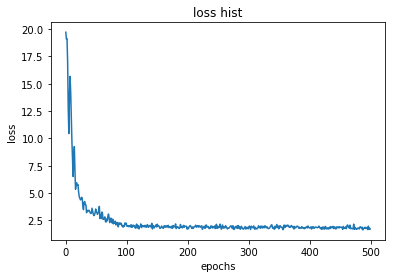

In [54]:
plt.plot(range(len(loss_arr)), loss_arr)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss hist')
plt.show()